# Health Insurance | Job-A-Thon
Author: Miguel Santana

### Project Methodology
FinMan Company is looking to leverage their client base by cross selling insurance products to existing customers. Insurance policies are offered to prospective and existing clients based on website landing and consumer election to fill out additional information forms. FinMan company would like to leverage their acquired information to classify positive leads for outreach programs using machine learning classifiers. 

### Data and Analytical Structure
The project dataset is provided by Analytics Vidhya via Kaggle. Data includes demographic features, policy features (for current customers) and example positive classifications for ML model validation and interpretation. The source can be found [here.](https://www.kaggle.com/imsparsh/jobathon-analytics-vidhya?select=sample_submission.csv) The project analysis will follow the OSEMN framework: Obtain, Scrub, Explore, Model and Interpret.

# Data & Packages | Obtain

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
pd.set_option('display.max_columns',50)

In [2]:
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

In [3]:
traindf = pd.read_csv('train.csv')
testdf = pd.read_csv('test.csv')

print(traindf.shape)
traindf.head(3)

(50882, 14)


,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1


# Data Cleaning | Scrub

## Null Values

In [4]:
traindf.isnull().sum()

ID                             0
City_Code                      0
Region_Code                    0
Accomodation_Type              0
Reco_Insurance_Type            0
Upper_Age                      0
Lower_Age                      0
Is_Spouse                      0
Health Indicator           11691
Holding_Policy_Duration    20251
Holding_Policy_Type        20251
Reco_Policy_Cat                0
Reco_Policy_Premium            0
Response                       0
dtype: int64

In [5]:
nonclients = ['Holding_Policy_Duration','Holding_Policy_Type']
for col in nonclients:
    traindf[col] = traindf[col].fillna(0)
    testdf[col] = testdf[col].fillna(0)

In [6]:
traindf['Health Indicator'] = traindf['Health Indicator'].fillna(traindf['Health Indicator'].mode()[0])
testdf['Health Indicator'] = testdf['Health Indicator'].fillna(testdf['Health Indicator'].mode()[0])

With many of these prospects not clearly identified as current clients, its safe to assume that null values in the 'Policy Duration' and 'Policy Type' columns are tied to non existing accounts and may be filled with zeros.

## Feature Engineering

Convert to numerical: Holding_Policy_Duration
    
* Feature engineer long term customers
* Convert '14+' to '15' / convert to numerical

Note: (**after EDA**) Convert to binary | Accomodation_Type, Reco_Insurance_Type, Is_Spouse

#### Categorical Features 

In [7]:
traindf['Long_Term_Cust'] = traindf['Holding_Policy_Duration'].apply(lambda x: 'Yes' if x == '14+' else 'No')
testdf['Long_Term_Cust'] = testdf['Holding_Policy_Duration'].apply(lambda x: 'Yes' if x == '14+' else 'No')

traindf['Holding_Policy_Duration'] = traindf['Holding_Policy_Duration'].replace('14+',15).astype(float).astype(int)
testdf['Holding_Policy_Duration'] = testdf['Holding_Policy_Duration'].replace('14+',15).astype(float).astype(int)

#### Renaming Features

In [8]:
traindf.rename(columns={'Is_Spouse':'Married','Health Indicator':'Health_Indicator'},inplace=True)
testdf.rename(columns={'Is_Spouse':'Married','Health Indicator':'Health_Indicator'},inplace=True)

traindf['Avg_Age'] = (traindf['Upper_Age'] + traindf['Lower_Age']) / 2
testdf['Avg_Age'] = (testdf['Upper_Age'] + testdf['Lower_Age']) / 2

Typically, insurance products are priced and underwritten based on the age of the applicant or applicants. This is especially the case in most health insurance pricing. To reflect this and retain data, an average age feature will be created and the original two features will be dropped. 

In [9]:
# feature engineering
traindf['Prim_Prem_Ratio'] = traindf['Reco_Policy_Premium'] / traindf['Upper_Age']
testdf['Prim_Prem_Ratio'] = testdf['Reco_Policy_Premium'] / testdf['Upper_Age']

## Feature Selection

In [10]:
traindf.drop(['ID','Region_Code','Upper_Age','Lower_Age'],axis=1,inplace=True)
testdf2 = testdf.copy()
testdf.drop(['ID','Region_Code','Upper_Age','Lower_Age'],axis=1,inplace=True)

The unique 'ID' and 'Region Code' columns will be dropped in order to simplify the data. 'Region Code' consists of far too many categorical values which would need to be one hot encoded. The feature is dropped as the data still retains the 'City Code' feature to capture some level of geographical distinction. In addition, the upper and lower age features will be dropped being represented by average age. 

In [11]:
numcols = testdf.select_dtypes('number').columns
for col in numcols:
    traindf[col] = traindf[col].astype(int)
    testdf[col] = testdf[col].astype(int)

In [12]:
# copy for final analysis
df = traindf.copy()

In [13]:
vals = {'Rented':1,'Owned':2,'Individual':1,'Joint':2,'No':0,'Yes':1}
cols = ['Accomodation_Type','Reco_Insurance_Type','Married','Long_Term_Cust']

for col in cols:
    traindf[col] = traindf[col].replace(vals)
    testdf[col] = testdf[col].replace(vals)

Features 'Accommodation Type', 'Reco Insurance Type', 'Is Spouse' will be converted to binary (0 and 1).

In [14]:
ordinal = ['Holding_Policy_Type','Reco_Policy_Cat']
for col in ordinal:
    traindf[col] = traindf[col].astype('O')
    testdf[col] = testdf[col].astype('O')

The two feature that stand out are 'Holding Policy Type' and 'Reco Policy Cat' which are listed under numerical but most likely correspond to type and category of policy in existing customers. 

# Exploratory Data Analysis

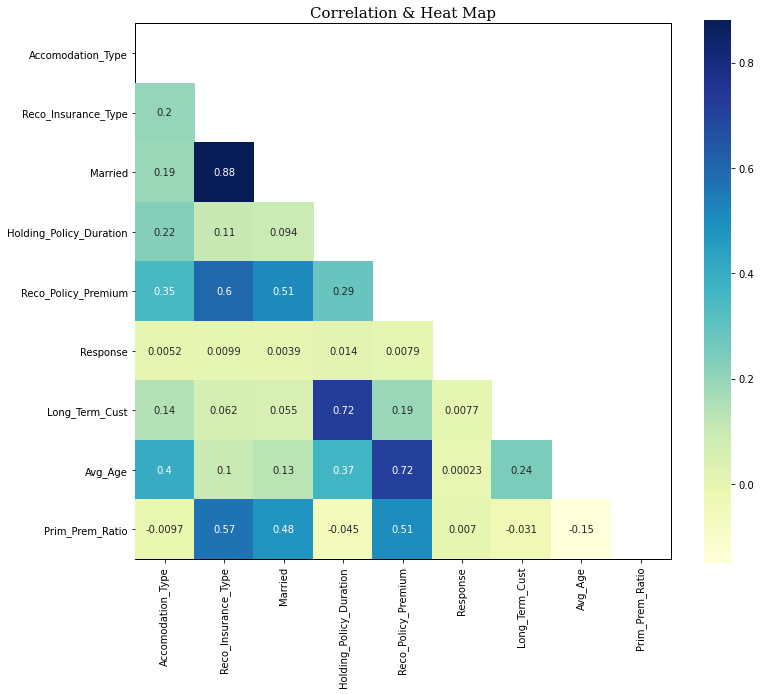

In [15]:
corr = traindf.corr() # analyzing correlation
fig, ax = plt.subplots(figsize=(12,10))
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, mask=mask, square=True, annot=True, cmap='YlGnBu')
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('1')
ax.set_title('Correlation & Heat Map', fontsize=15, fontfamily='serif')
plt.show()

In [16]:
traindf.drop(['Married'],axis=1,inplace=True)
testdf.drop(['Married'],axis=1,inplace=True)

Final feature selection due to multicollinearity. 

In [17]:
targetdf = df.groupby('Response').mean().head()
targetdf.style.background_gradient(cmap='Reds')

,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Avg_Age,Prim_Prem_Ratio
Response,,,,,,
0,3.668554,1.463915,14.707910,14154.494816,43.738888,317.916712
1,3.826194,1.482677,16.405275,14277.072406,43.748219,319.431649


Customers who elect to receive additional information typically hold existing policies longer and are classified under a larger policy category with a slightly larger premium. 

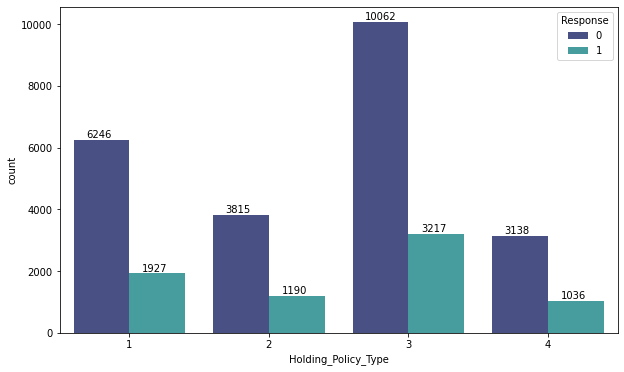

In [18]:
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.countplot(data=df[df['Holding_Policy_Type']!=0],x='Holding_Policy_Type',hue='Response',palette='mako');
for p in ax.patches:
        ax.annotate(p.get_height(),(p.get_x()+0.09, p.get_height()+75))
fig.savefig('policytypecount.jpg',dpi=200,bbox_inches='tight')

Holding Policy Type three has the highest number of positive responses but all four of the categories have approximately 30% positive to negative client responses.  

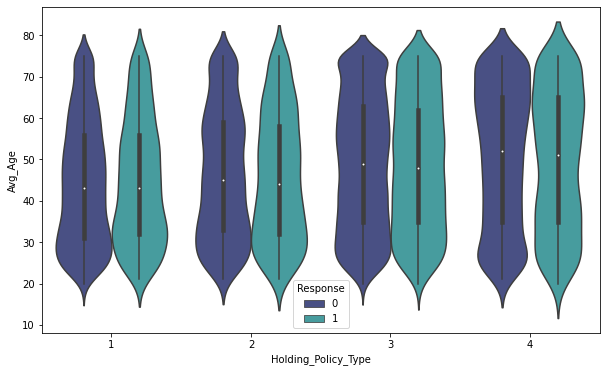

In [19]:
fig, ax = plt.subplots(figsize=(10,6))
sns.violinplot(data=df[df['Holding_Policy_Type']!=0],x='Holding_Policy_Type',y='Avg_Age',hue='Response',palette='mako');
fig.savefig('policytypexage.jpg',dpi=200,bbox_inches='tight')

The violin plot gives an interesting take on Average Age versus Holding Policy Type. HPT 3 shows a pretty even distribution across age groups while HPT 1 is heavily made up of younger individuals. 

In [20]:
traincat_vars = [var for var in traindf.columns if traindf[var].dtype == 'O']
testcat_vars = [var for var in testdf.columns if testdf[var].dtype == 'O']

## Final Transformations

In [21]:
def replace_categories(df, var, target):
    # Order variable categories | lowest to highest against target (price)
    ordered_labels = df.groupby([var])[target].mean().sort_values().index
    # Dictionary of ordered categories to integer values
    ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}
    # Replace the categorical strings by integers using dictionary
    df[var] = df[var].map(ordinal_label)

In [22]:
for var in traincat_vars:
    replace_categories(traindf, var, 'Avg_Age')

In [23]:
for var in testcat_vars:
    replace_categories(testdf, var, 'Avg_Age')

With each of the categorical values mapped to values with respect to average age, the resulting values will end up on a similar scale as the rest of the dataset. In order to minimize data manipulation for modeling, no label encoding or standard scaling will occur. 

In [24]:
# labelencoder = preprocessing.LabelEncoder()
# scaler = preprocessing.StandardScaler()

In [25]:
# traindf['City_Code'] = labelencoder.fit_transform(traindf['City_Code'])
# testdf['City_Code'] = labelencoder.fit_transform(testdf['City_Code'])
# traindfscaled = scaler.fit_transform(traindf)
# testdfscaled = scaler.fit_transform(testdf)

# Model
## Pycaret

In [26]:
import pycaret
import pycaret.preprocess as preprocess
from pycaret.datasets import get_data
from pycaret.classification import *
import pycaret.preprocess as preprocess

In [27]:
dataset = traindf.copy()
data = dataset.sample(frac=0.80, random_state=786)
data_unseen = dataset.drop(data.index).reset_index(drop=True)
print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (40706, 12)
Unseen Data For Predictions: (10176, 12)


In [28]:
clf = setup(data=data,target='Response',session_id=123,numeric_features=['Long_Term_Cust','Health_Indicator','Accomodation_Type','Reco_Insurance_Type','Holding_Policy_Duration','Holding_Policy_Type'])

Setup Succesfully Completed!


,Description,Value
0,session_id,123
1,Target Type,Binary
2,Label Encoded,"0: 0, 1: 1"
3,Original Data,"(40706, 12)"
4,Missing Values,False
5,Numeric Features,11
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [29]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Logistic Regression,0.7593,0.4983,0.0000,0.0000,0.0000,0.0000,0.0000,0.0626
1,Naive Bayes,0.7593,0.5027,0.0000,0.0000,0.0000,0.0000,0.0000,0.0052
2,Ridge Classifier,0.7593,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0080
3,Linear Discriminant Analysis,0.7593,0.4978,0.0000,0.0000,0.0000,0.0000,0.0000,0.0330
4,Ada Boost Classifier,0.7591,0.6114,0.0002,0.1000,0.0004,-0.0001,-0.0010,0.4386
5,Quadratic Discriminant Analysis,0.7584,0.5317,0.0011,0.2625,0.0022,-0.0006,0.0006,0.0081
6,Gradient Boosting Classifier,0.7583,0.6373,0.0031,0.2891,0.0061,0.0013,0.0077,1.4701
7,Extreme Gradient Boosting,0.7583,0.6371,0.0047,0.4256,0.0093,0.0029,0.0164,0.4215
8,Light Gradient Boosting Machine,0.7564,0.6461,0.0215,0.4003,0.0407,0.0161,0.0418,0.4177
9,CatBoost Classifier,0.7562,0.6382,0.0272,0.4077,0.0508,0.0213,0.0494,12.6663


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#### SMOTE | Balanced Target

In [30]:
clf = setup(data=data,target='Response',session_id=123,fix_imbalance=True,numeric_features=['Long_Term_Cust','Health_Indicator','Accomodation_Type','Reco_Insurance_Type','Holding_Policy_Duration','Holding_Policy_Type'])

Setup Succesfully Completed!


,Description,Value
0,session_id,123
1,Target Type,Binary
2,Label Encoded,"0: 0, 1: 1"
3,Original Data,"(40706, 12)"
4,Missing Values,False
5,Numeric Features,11
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [31]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Extreme Gradient Boosting,0.7578,0.6121,0.0111,0.4055,0.0216,0.0085,0.0304,0.4949
1,Light Gradient Boosting Machine,0.7577,0.6452,0.0275,0.4456,0.0517,0.0245,0.0585,0.3628
2,Gradient Boosting Classifier,0.7574,0.6108,0.0115,0.3748,0.0222,0.0081,0.0269,3.5025
3,CatBoost Classifier,0.7545,0.6363,0.0388,0.4004,0.0706,0.0292,0.0573,12.5612
4,Ada Boost Classifier,0.7339,0.5561,0.0642,0.2726,0.1027,0.0139,0.0185,0.9117
5,Extra Trees Classifier,0.7309,0.5686,0.0997,0.3133,0.1511,0.0399,0.0491,0.4698
6,Random Forest Classifier,0.7276,0.5496,0.0999,0.3021,0.1499,0.0344,0.0420,0.1122
7,Decision Tree Classifier,0.6457,0.5342,0.3189,0.2874,0.3023,0.0657,0.0659,0.1506
8,SVM - Linear Kernel,0.5517,0.0000,0.4000,0.0962,0.1551,0.0000,0.0000,0.5937
9,K Neighbors Classifier,0.5284,0.4988,0.4418,0.2398,0.3108,-0.0018,-0.0020,0.0309


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=0)

Both cases gave very similar results. Light Gradient Boosting offered the highest AUC value in both scenarios. SMOTE will not be included in our final model. 

## Scikit-learn

In [32]:
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

In [33]:
def model_visuals (model, X_test, y_test):
    '''Plots the confusion matrix and ROC-AUC plot'''
    fig, axes = plt.subplots(figsize = (12, 6), ncols = 2)  # confusion matrix
    metrics.plot_confusion_matrix(model, X_test, y_test, normalize = 'true', 
                          cmap = 'Blues', ax = axes[0])
    axes[0].set_title('Confusion Matrix');
    # ROC-AUC Curve
    roc_auc = metrics.plot_roc_curve(model, X_test, y_test,ax=axes[1])
    axes[1].plot([0,1],[0,1],ls=':')
    axes[1].set_title('ROC-AUC Plot')
    axes[1].grid()
    axes[1].legend()
    fig.tight_layout()
    plt.show()

In [34]:
X_train, X_test, y_train, y_test = train_test_split(traindf.drop(columns=['Response'],axis=1),traindf['Response'],test_size=0.2, random_state=42)

### GridSearchCV

In [35]:
gbclf = GradientBoostingClassifier(random_state=42)
gbclf.fit(X_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [36]:
param_grid = {
    'learning_rate': [0.1,0.2],
    'max_depth': [6],
    'subsample': [0.5,0.7,1],
    'n_estimators': [100]
}

In [37]:
grid_clf = GridSearchCV(gbclf,param_grid,scoring='roc_auc',cv=None,n_jobs=1)
grid_clf.fit(X_train,y_train)

best_parameters = grid_clf.best_params_

print('Grid search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name,best_parameters[param_name]))
    
training_preds = grid_clf.predict(X_train)
test_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train,training_preds)
test_accuracy = accuracy_score(y_test,test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy*100))
print('Validation Accuracy: {:.4}%'.format(test_accuracy*100))

Grid search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 6
n_estimators: 100
subsample: 1

Training Accuracy: 77.44%
Validation Accuracy: 75.66%


Similar accuracy in the training and test sets suggests minimal under/over fitting.

# Final Model

In [38]:
gbclf = GradientBoostingClassifier(max_depth=6,learning_rate=0.1,n_estimators=100,subsample=1,random_state=42)
gbclf.fit(X_train,y_train)
# predict
training_preds = gbclf.predict(X_train)
test_preds = gbclf.predict(X_test)
# accuracy
training_accuracy = accuracy_score(y_train,training_preds)
test_accuracy = accuracy_score(y_test,test_preds)

              precision    recall  f1-score   support

           0       0.76      0.99      0.86      7688
           1       0.56      0.02      0.05      2489

    accuracy                           0.76     10177
   macro avg       0.66      0.51      0.45     10177
weighted avg       0.71      0.76      0.66     10177
 




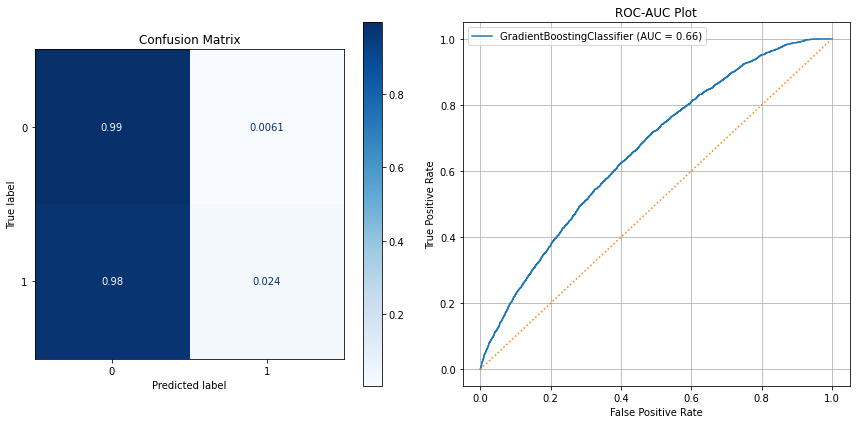

In [39]:
print(classification_report(y_test, test_preds), '\n\n')
model_visuals (gbclf, X_test, y_test) # class report / plots

# Interpret Results
## Feature Importance

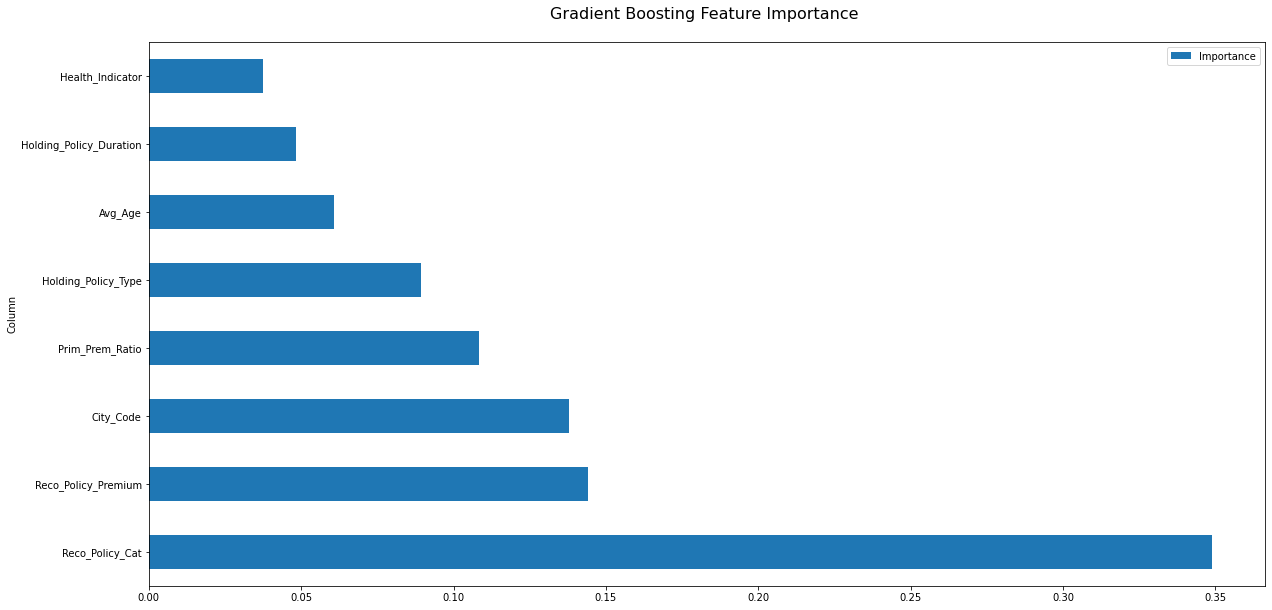

In [40]:
# Feature Importance
X = traindf.drop(columns=['Response'],axis=1)
clf_feature = pd.DataFrame({'Importance':gbclf.feature_importances_,'Column':X.columns})
clf_feature = clf_feature.sort_values(by='Importance',ascending=False) 
clf_feature = clf_feature[:8] # top 8 features
clf_feature.plot(kind='barh',x='Column',y='Importance',figsize=(20, 10))
plt.title('Gradient Boosting Feature Importance \n',fontsize=16)
plt.savefig('featureimportance.jpg',dpi=200,bbox_inches='tight')
plt.show()

### Reco Policy Category

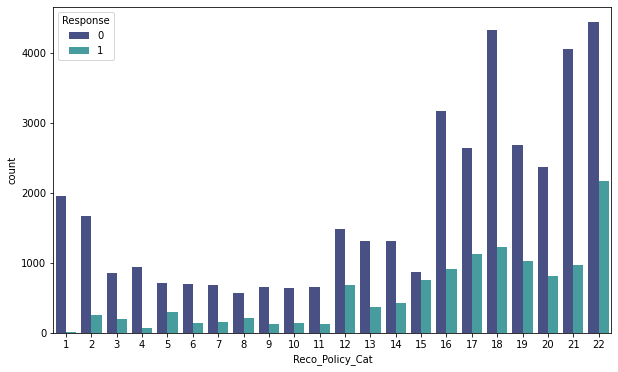

In [41]:
df['Reco_Policy_Cat'] = df['Reco_Policy_Cat'].astype('O')

fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(data=df,x='Reco_Policy_Cat',hue='Response',palette='mako');
fig.savefig('policycategoryxresponse.jpg',dpi=200,bbox_inches='tight')

This graph may be misleading as each policy category caries a significantly different client count. Lets break down the top five categories based on positive over total responses. 

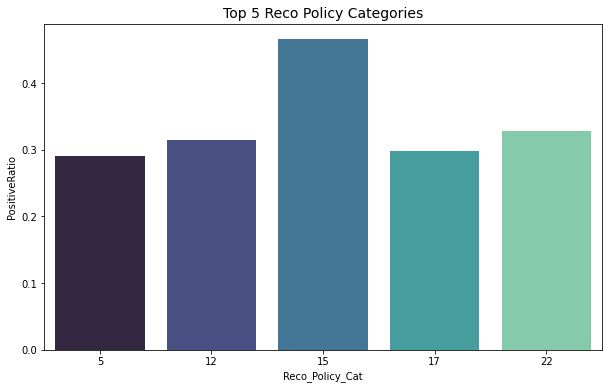

In [42]:
RPC = df.groupby(['Reco_Policy_Cat','Response'])['Response'].count().unstack()
RPC['PositiveRatio'] = RPC[1] / (RPC[1] + RPC[0])
RPC = RPC.sort_values(by='PositiveRatio', ascending=False)[:5].reset_index()
# RPC
fig, ax = plt.subplots(figsize=(10,6))
plt.title('Top 5 Reco Policy Categories', fontdict={'fontsize': 14})
sns.barplot(data=RPC,x='Reco_Policy_Cat',y='PositiveRatio',palette='mako');
fig.savefig('top5categoryxresponse.jpg',dpi=200,bbox_inches='tight')

Reco Policy Category 15 is the clear front runner

### Reco Policy Premium

In [43]:
# Binning Ages for Visualizations
df['Premium(bin)'] = df['Reco_Policy_Premium'].apply(lambda x: '0-9999' if x < 10000
                                                     else '10000-14999' if x < 15000 
                                                     else '15000-19999' if x < 20000 
                                                     else '20000-24999' if x < 25000 
                                                     else '25000-29999' if x < 30000 
                                                     else '30000+')

In [44]:
# dashboard analysis
df.to_csv('jobathondashboard.csv')

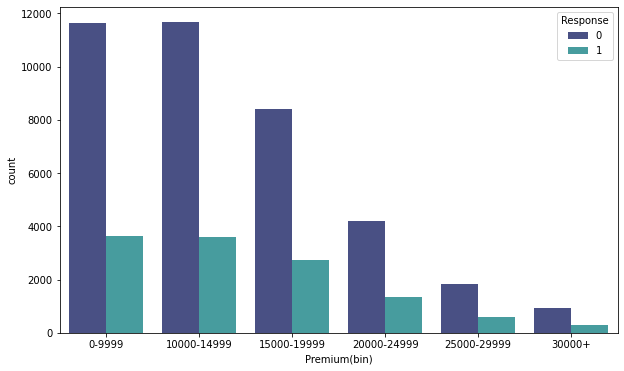

In [45]:
df = df.sort_values(['Premium(bin)'], ascending=True)
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(data=df,x='Premium(bin)',hue='Response',palette='mako');
fig.savefig('premiumbin.jpg',dpi=200,bbox_inches='tight')

Lets confirm the positive to total response ratios before we make a recommendation. 

In [46]:
PRE = df.groupby(['Premium(bin)','Response'])['Response'].count().unstack()
PRE['PositiveRatio'] = PRE[1] / (PRE[1] + PRE[0])
PRE = PRE.sort_values(by='PositiveRatio', ascending=False)
PRE

Response,0,1,PositiveRatio
Premium(bin),,,
25000-29999,1824,602,0.248145
15000-19999,8420,2733,0.245046
30000+,931,300,0.243704
20000-24999,4188,1333,0.241442
0-9999,11638,3642,0.238351
10000-14999,11672,3599,0.235675


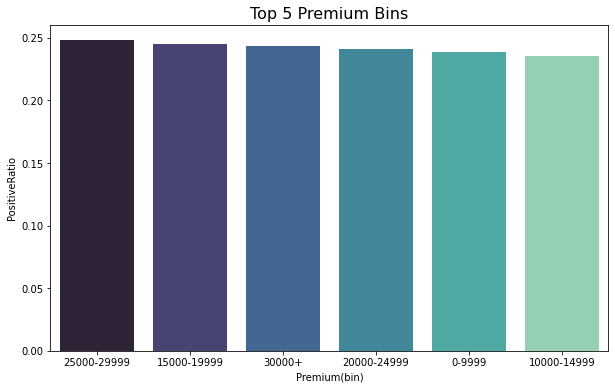

In [47]:
PRE = PRE.reset_index()
fig, ax = plt.subplots(figsize=(10,6))
plt.title('Top 5 Premium Bins', fontdict={'fontsize': 16})
sns.barplot(data=PRE,x='Premium(bin)',y='PositiveRatio',palette='mako');
fig.savefig('top5premiumbin.jpg',dpi=200,bbox_inches='tight')

In this case, most of the ratios are extremely close so the recommendation would be to focus on individuals who pay an annual premium between 15,000 and 19,999 as they convert at approximately the same rate as the front runner but represent a much larger group of clients. The high conversion along with the larger client volume will lead to higher profit. 

### City Code

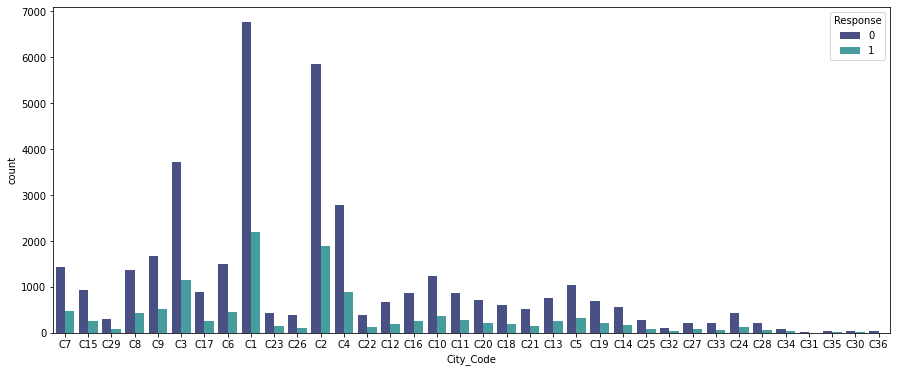

In [48]:
fig, ax = plt.subplots(figsize=(15,6))
sns.countplot(data=df,x='City_Code',hue='Response',palette='mako');
fig.savefig('citycode.jpg',dpi=200,bbox_inches='tight')

In [49]:
CITY = df.groupby(['City_Code','Response'])['Response'].count().unstack()
CITY['PositiveRatio'] = CITY[1] / (CITY[1] + CITY[0])
CITY = CITY.sort_values(by='PositiveRatio', ascending=False)[:11]
CITY

Response,0,1,PositiveRatio
City_Code,,,
C30,40,18,0.310345
C32,114,46,0.287500
C35,40,16,0.285714
C34,94,36,0.276923
C23,431,156,0.265758
C27,219,76,0.257627
C13,750,255,0.253731
C7,1426,484,0.253403
C33,215,71,0.248252


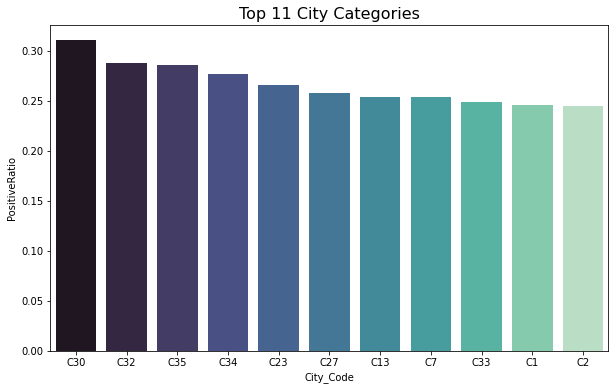

In [50]:
CITY = CITY.reset_index()
fig, ax = plt.subplots(figsize=(10,6))
plt.title('Top 11 City Categories', fontdict={'fontsize': 16})
sns.barplot(data=CITY,x='City_Code',y='PositiveRatio',palette='mako');
fig.savefig('top11citycode.jpg',dpi=200,bbox_inches='tight')

In this particular case I would recommend focusing on the top 11 scoring positive ratios. Ranks 10 and 11 are exponentially larger in volume than the first 9 and have the potential to yield high ROI with positive to total ratios close to 25%. 

### Submission

In [51]:
features = testdf.columns
target = ['Response']

In [52]:
# preparing submission
gbclf.fit(traindf[features], traindf[target].values.ravel())
predictions = gbclf.predict_proba(testdf[features])[:,1]
submission = pd.DataFrame({'ID': testdf2['ID'],'Response': predictions})

In [53]:
submission['Response'].describe()

count    21805.000000
mean         0.233602
std          0.089300
min          0.006746
25%          0.176038
50%          0.232972
75%          0.287697
max          0.825420
Name: Response, dtype: float64

In [54]:
submission['Response'] = submission['Response'].apply(lambda x: 0 if x < 0.3 else 1)

In following the theme of the test and train datasets as well as presenting a client list of a respectable size, the cut off for positive response predictions will be 30%. 

In [55]:
submission.to_csv('submission.csv', index=False)

## Recommendations
The model's top 3 features were Reco Policy Category, Reco Policy Premium and City Code. Within those three categories, subcategories yielded the highest positive to total response ratios. It is recommended to focus on clients in/with:

City Codes: C1, C2, C13, C23
Reco Policy Categories: 15, 22
Reco Policy Premiums between: 15,000 & 19,000.

#### Limitations
The project was limited by the anonymity of the data. Specifically the geographic data that could have been used for additional feature engineering leading to higher scores.

#### Future Work
Future models can be created using more complicated feature engineering and analysis such as clustering of the geographic features. For the purposes of this project, doing so would have complicated the output and made it difficult to implement within a real workplace.

For any additional questions, please reach out via email at santana2.miguel@gmail.com, on [LinkedIn](https://www.linkedin.com/in/miguel-angel-santana-ii-mba-51467276/) or on [Twitter.](https://twitter.com/msantana_ds)